In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

from hiEEG_functions import *

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# iEEG Macroelectrode Data (4kHz)

In [3]:
folder='./data/hiEEG'

# Load file manually
# file_string = f'Data_Subject_{1:02d}_Session_{1:02d}'
# f = h5py.File(os.path.join(folder, file_string) + '.h5', 'r')

# Load file automatically
data, meta, fname = load_iEEG_macro(1, 1, folder=folder)

## Visualize

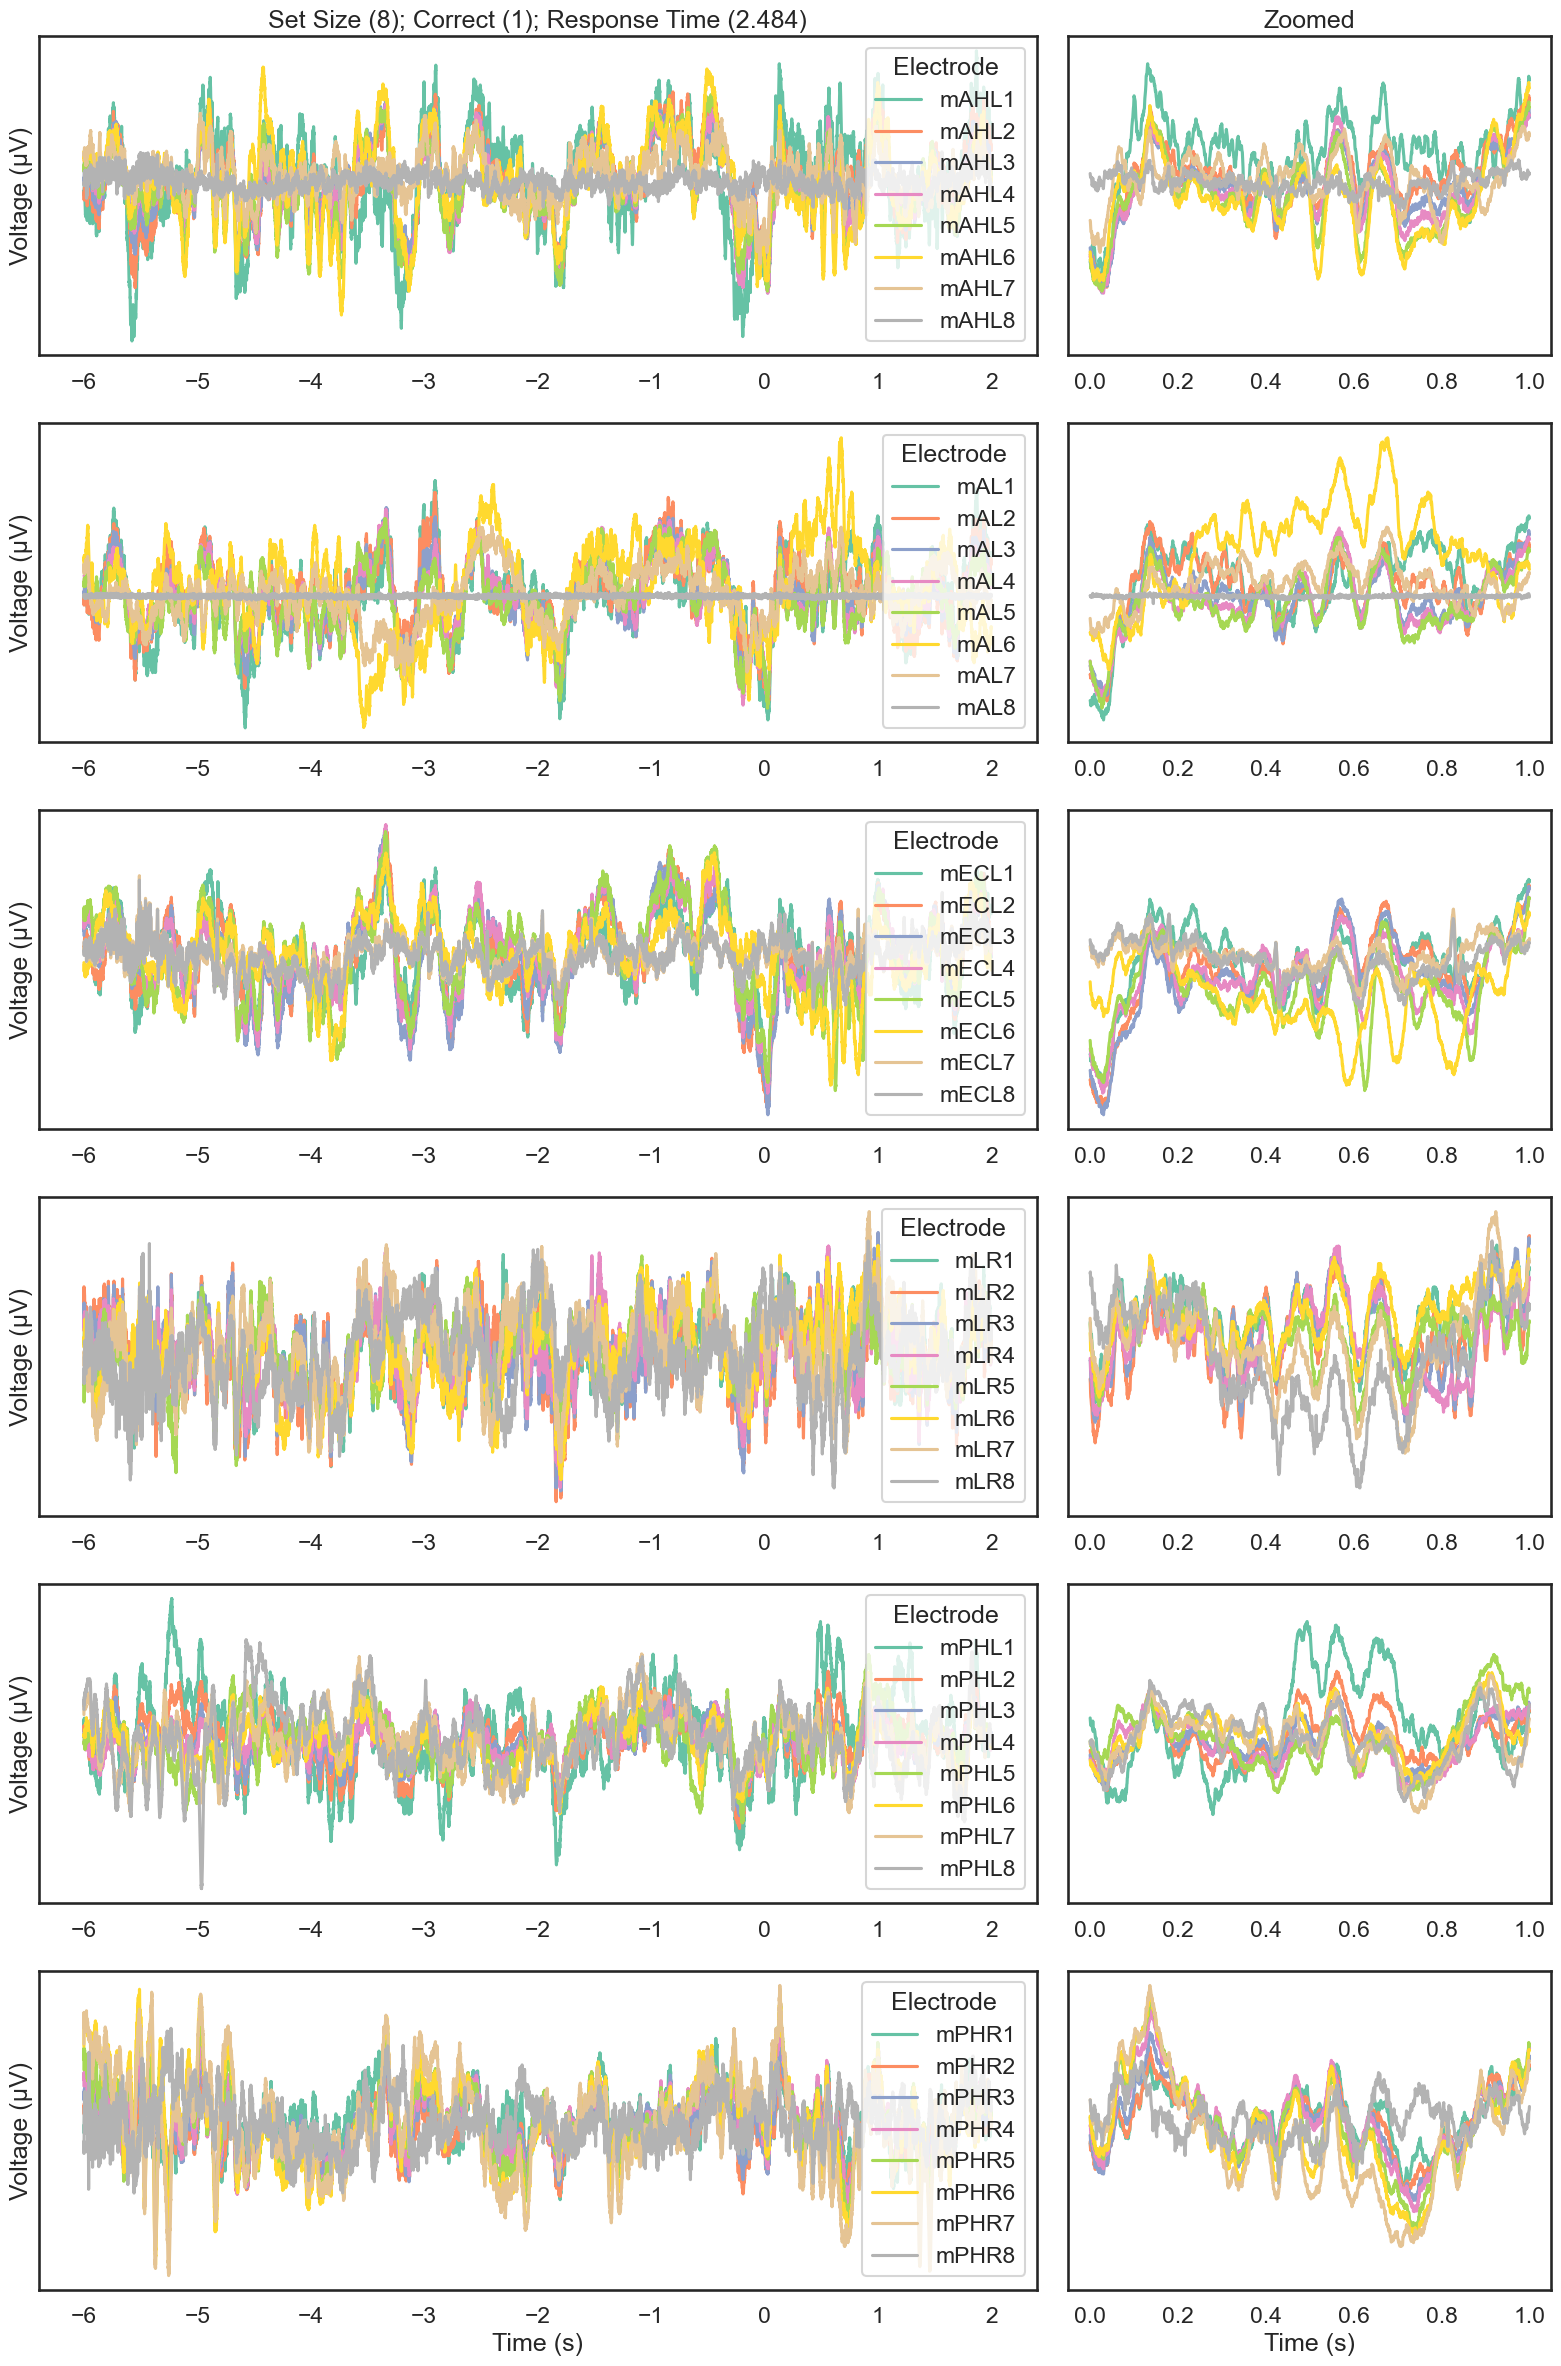

In [4]:
# TODO: Plot brain coordinates
# Set variables
trial_num = 0
time, waveform, electrode_names = data[trial_num]['time'], data[trial_num]['waveform'], data[trial_num]['electrodes']
set_size, correct, response_time = meta[trial_num]['set_size'], meta[trial_num]['correct'], meta[trial_num]['response_time']
df = (
    pd.DataFrame(waveform, index=electrode_names, columns=time)
        .reset_index(names='Electrode')
        .melt(id_vars='Electrode', var_name='Time (s)', value_name='Voltage (μV)')
)

# Make figure
scale = 4
split = int(48/8)  # How many sections?
fig, axs = plt.subplot_mosaic([4*[i] + 2*[i+1] for i in range(0, split*2, 2)], figsize=(scale*4, scale*split))  # sharex=True
# Share x across all vertically stacked plots
[axs[i].sharex(axs[i+2]) for i in range(0, (split*2)-2, 2)]
[axs[(i+1)].sharex(axs[(i+1)+2]) for i in range(0, (split*2)-2, 2)]

# Plot
for i in range(0, split*2, 2):
    # Variables
    last = i == split*2-2

    # Filter to electrodes
    df_filtered = df.loc[df['Electrode'].map(lambda x: x in electrode_names[int(i/2*electrode_names.shape[0]/split):int((i/2+1)*electrode_names.shape[0]/split)])]

    # Regular plot
    plt.sca(axs[i])
    sns.lineplot(
        data=df_filtered,
        x='Time (s)',
        y='Voltage (μV)',
        hue='Electrode',
        ax=axs[i])
    if not last: axs[i].set_xlabel(None)

    # Zoomed plot
    sns.lineplot(
        data=df_filtered.loc[(df_filtered['Time (s)'] >= 0) * (df_filtered['Time (s)'] <= 1)],
        x='Time (s)',
        y='Voltage (μV)',
        hue='Electrode',
        legend=False,
        ax=axs[i+1])
    if not last: axs[i+1].set_xlabel(None)
    axs[i+1].set_ylabel(None)
    axs[i+1].set_yticks([])

    # Share y axis
    axs[i].sharey(axs[i+1])

    # Title based on meta
    if i == 0:
        axs[i].set_title(f'Set Size ({int(set_size):d}); Correct ({int(correct):d}); Response Time ({response_time:.3f})')
        axs[i+1].set_title('Zoomed')

# Formatting
plt.tight_layout()

# iEEG Microelectrode Data (32kHz)

In [5]:
folder = './data/New hiEEG/000574'  # './data/hiEEG/000574'

# Load file manually
# file_string = f'sub-01/sub-01_ses-20161214T173600_behavior+ecephys.nwb'
# nwbfile = pynwb.NWBHDF5IO(os.path.join(folder, file_string), mode='r').read()

# Load file automatically
micro_data, micro_meta = load_iEEG_micro(2, 2, folder=folder, format='new')  # Can use `format='old'` for old format
get_nwb_sizes(os.path.join(folder, 'sub-02/sub-02_ses-01.nwb'))  # Show sizes of groups in file

,Uncompressed,Compressed
acquisition,6.459845e+00,2.473119e+00
analysis,0.000000e+00,0.000000e+00
file_create_date,7.450581e-09,1.490116e-08
general,5.893409e-06,8.769333e-06
identifier,7.450581e-09,1.490116e-08
intervals,1.127180e-05,1.382735e-05
processing,0.000000e+00,0.000000e+00
session_description,7.450581e-09,1.490116e-08
session_start_time,7.450581e-09,1.490116e-08
specifications,1.490116e-07,2.980232e-07


In [8]:
# # Check regions across all subjects and trials
# i = 1
# session_df = []
# while True:
#     j = 1
#     while True:
#         # Read data
#         try: micro_data, micro_meta = load_iEEG_micro(i, j, folder=folder, format='new')
#         except: break

#         # Record
#         print(f'{i} - {j}', end='; ')
#         session_df.append({
#             'Subject': i,
#             'Session': j,
#             'Trials Measured': detect_trials(micro_data['time'], micro_data['waveform'])['time'].shape[0],
#             'Trials Meta': micro_meta['trial'].shape[0],
#             'Electrodes': micro_data['electrode_regions'].shape[0],
#             'Region Mapping': {region: np.argwhere(micro_data['electrode_major_regions']==region).flatten() for region in np.unique(micro_data['electrode_major_regions'])},
#         })
#         j += 1
#     if j == 1: break
#     i += 1
# session_df = pd.DataFrame(session_df)
# session_df.to_csv('./exports/new_data.csv', index=None)
# # session_df = pd.read_csv('./exports/new_data.csv')

# # Print counts
# counts = {}
# for mapping in session_df['Region Mapping']:
#     for k, v in mapping.items():
#         if k not in counts: counts[k] = 0
#         counts[k] += len(v)
# for k, v in counts.items(): print(f'{k}: {v}')

# # For validation, note
# assert sum([v for v in counts.values()]) / session_df.shape[0] == session_df['Electrodes'].mean()

## Visualize

### Electrode Location

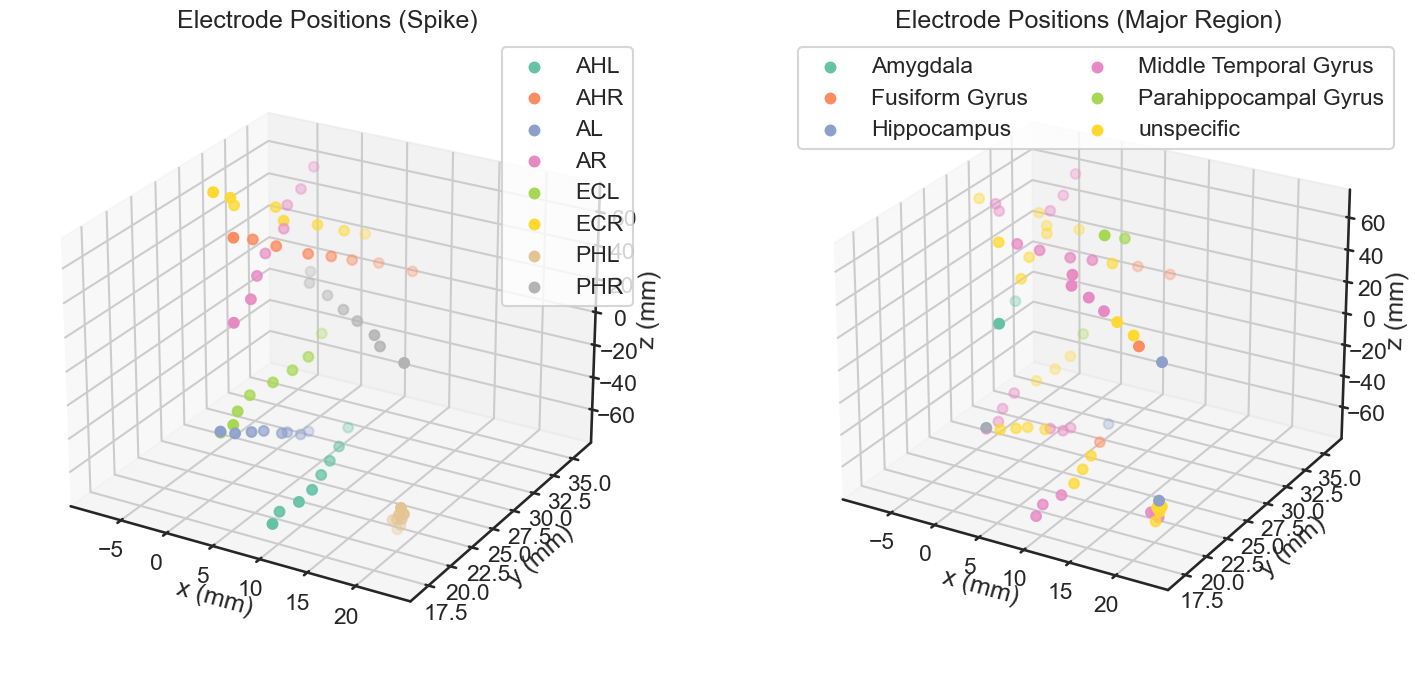

In [9]:
# Show electrode positions colored by spike
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(1, 2, 1, projection='3d')
for idx in range(int(micro_data['electrodes'].shape[0] / 8)):
    filtered_data = micro_data['electrode_positions'][idx*8:(idx+1)*8]
    ax.scatter(*filtered_data.T, label=micro_data['electrodes'][idx*8][:-1], s=50)
ax.legend()
ax.set_title('Electrode Positions (Spike)')
ax.set_xlabel('x (mm)'); ax.set_ylabel('y (mm)'); ax.set_zlabel('z (mm)')
ax.set_box_aspect(aspect=None, zoom=.95)
ax.view_init(elev=25, azim=300)

# Show electrode
ax = fig.add_subplot(1, 2, 2, projection='3d')
labels = micro_data['electrode_major_regions']
for label in np.unique(labels):
    mask = labels == label
    filtered_data = micro_data['electrode_positions'][mask]
    ax.scatter(*filtered_data.T, label=label, s=50)
ax.legend(ncols=2)
ax.set_title('Electrode Positions (Major Region)')
ax.set_xlabel('x (mm)'); ax.set_ylabel('y (mm)'); ax.set_zlabel('z (mm)')
ax.set_box_aspect(aspect=None, zoom=.91)
ax.view_init(elev=25, azim=300)

### Waveform

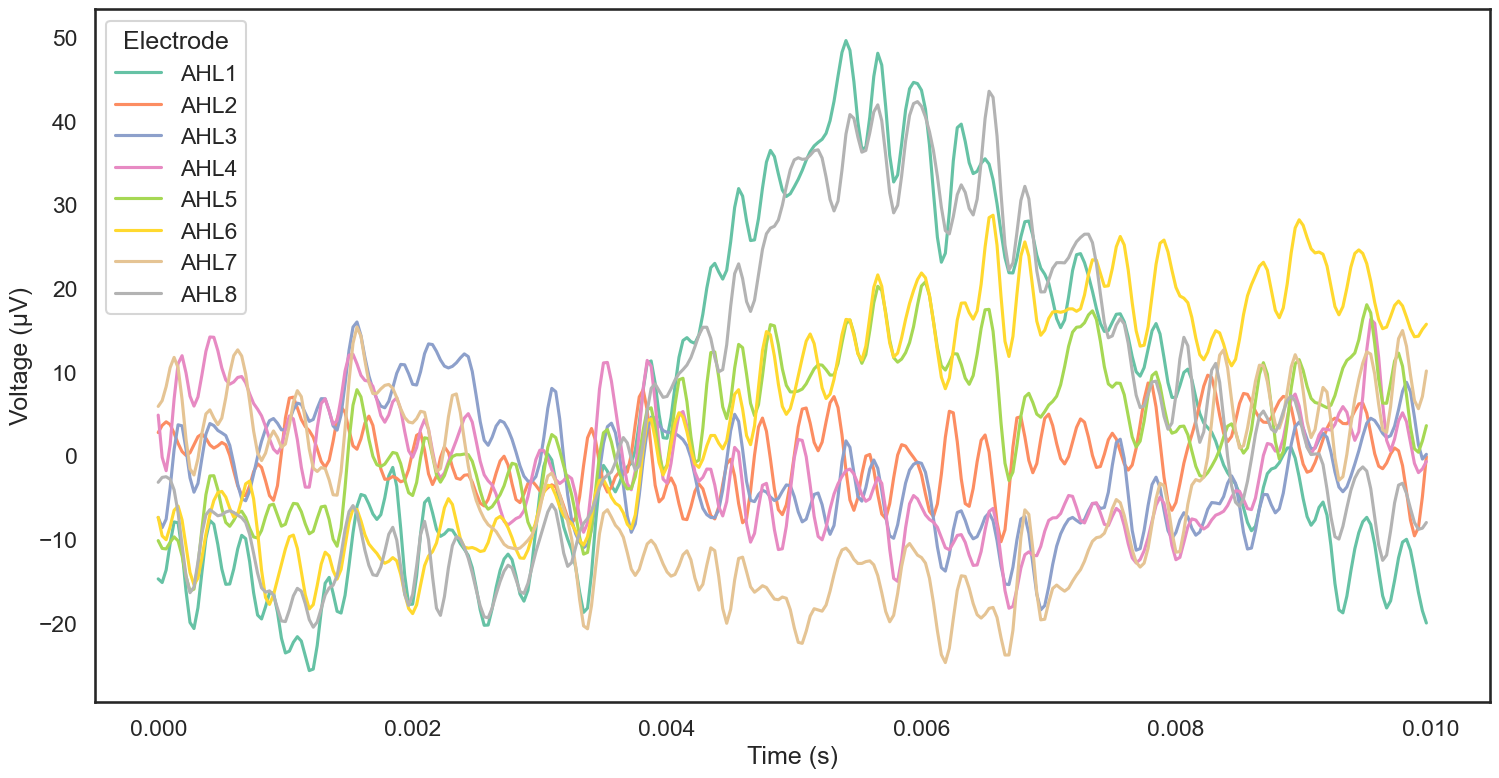

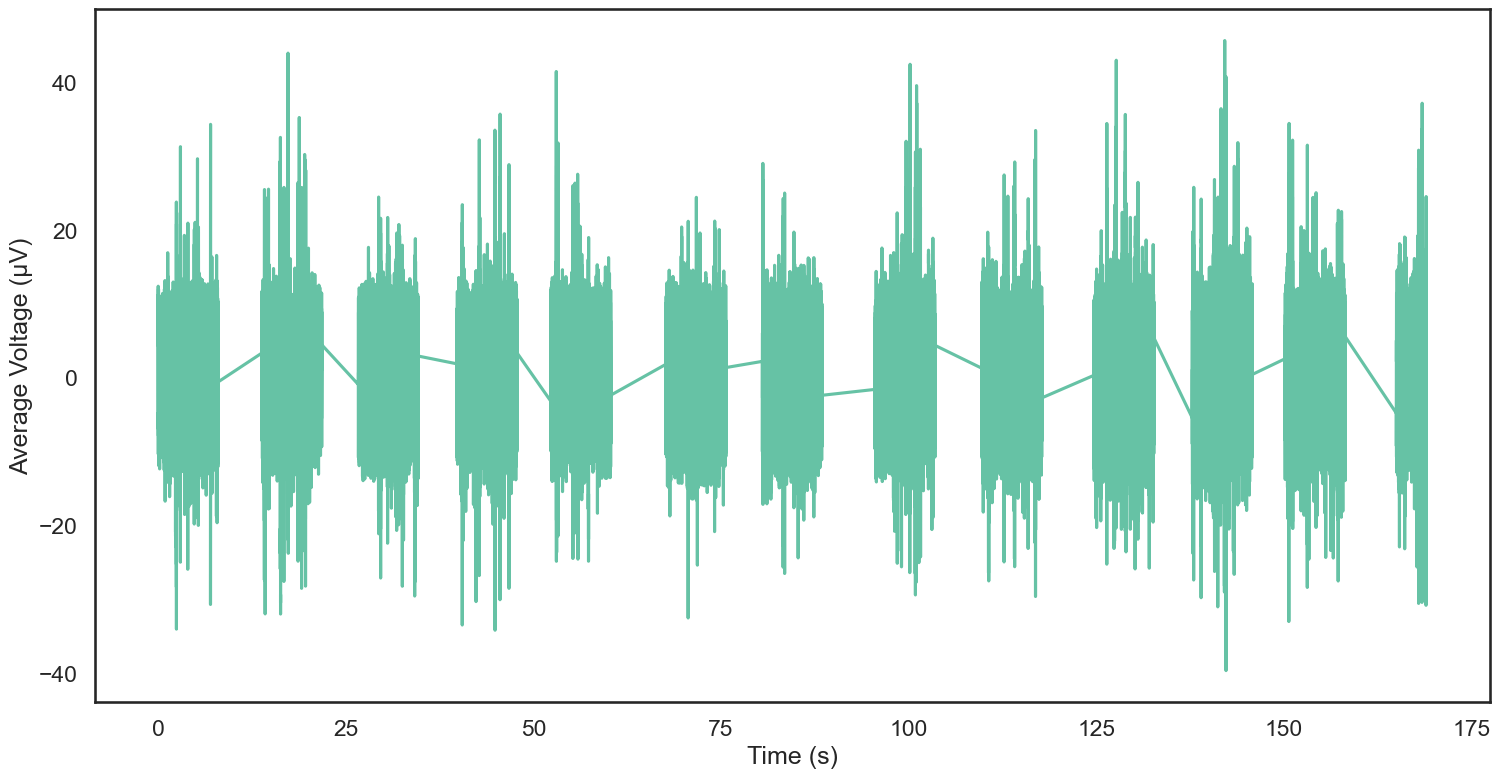

In [10]:
# Plot individual
idx = list(range(int(.01 * 32_000)))
df = pd.DataFrame(micro_data['waveform'][idx], index=pd.Series(micro_data['time'][idx], name='Time (s)'), columns=micro_data['electrodes'])
df = df.reset_index().melt(id_vars='Time (s)', var_name='Electrode', value_name='Voltage (μV)')
step = 8
for i in range(0, micro_data['waveform'].shape[1], step):
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    df_filtered = df.iloc[[s in list(micro_data['electrodes'][i:i+8]) for s in df['Electrode']]]
    sns.lineplot(df_filtered, x='Time (s)', y='Voltage (μV)', hue='Electrode', ax=ax)
    plt.show()
    break  # Remove to show all groups

# Plot average
df = pd.DataFrame({'Time (s)': micro_data['time'], 'Average Voltage (μV)': micro_data['waveform'].mean(axis=1)})
idx = list(range(int(100 * 32_000)))
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
sns.lineplot(df.iloc[idx], x='Time (s)', y='Average Voltage (μV)', ax=ax)
plt.show()

In [11]:
# Separete waveform into multiple segments
trials = detect_trials(micro_data['time'], micro_data['waveform'])
print(f'There are {len(trials["time"])} trials, {trials["time"][0].shape[0] / 32e3:.1f}s each ({trials["time"][0].shape[0]} timepoints).')

There are 47 trials, 8.0s each (256000 timepoints).


### Magnitude Correlation

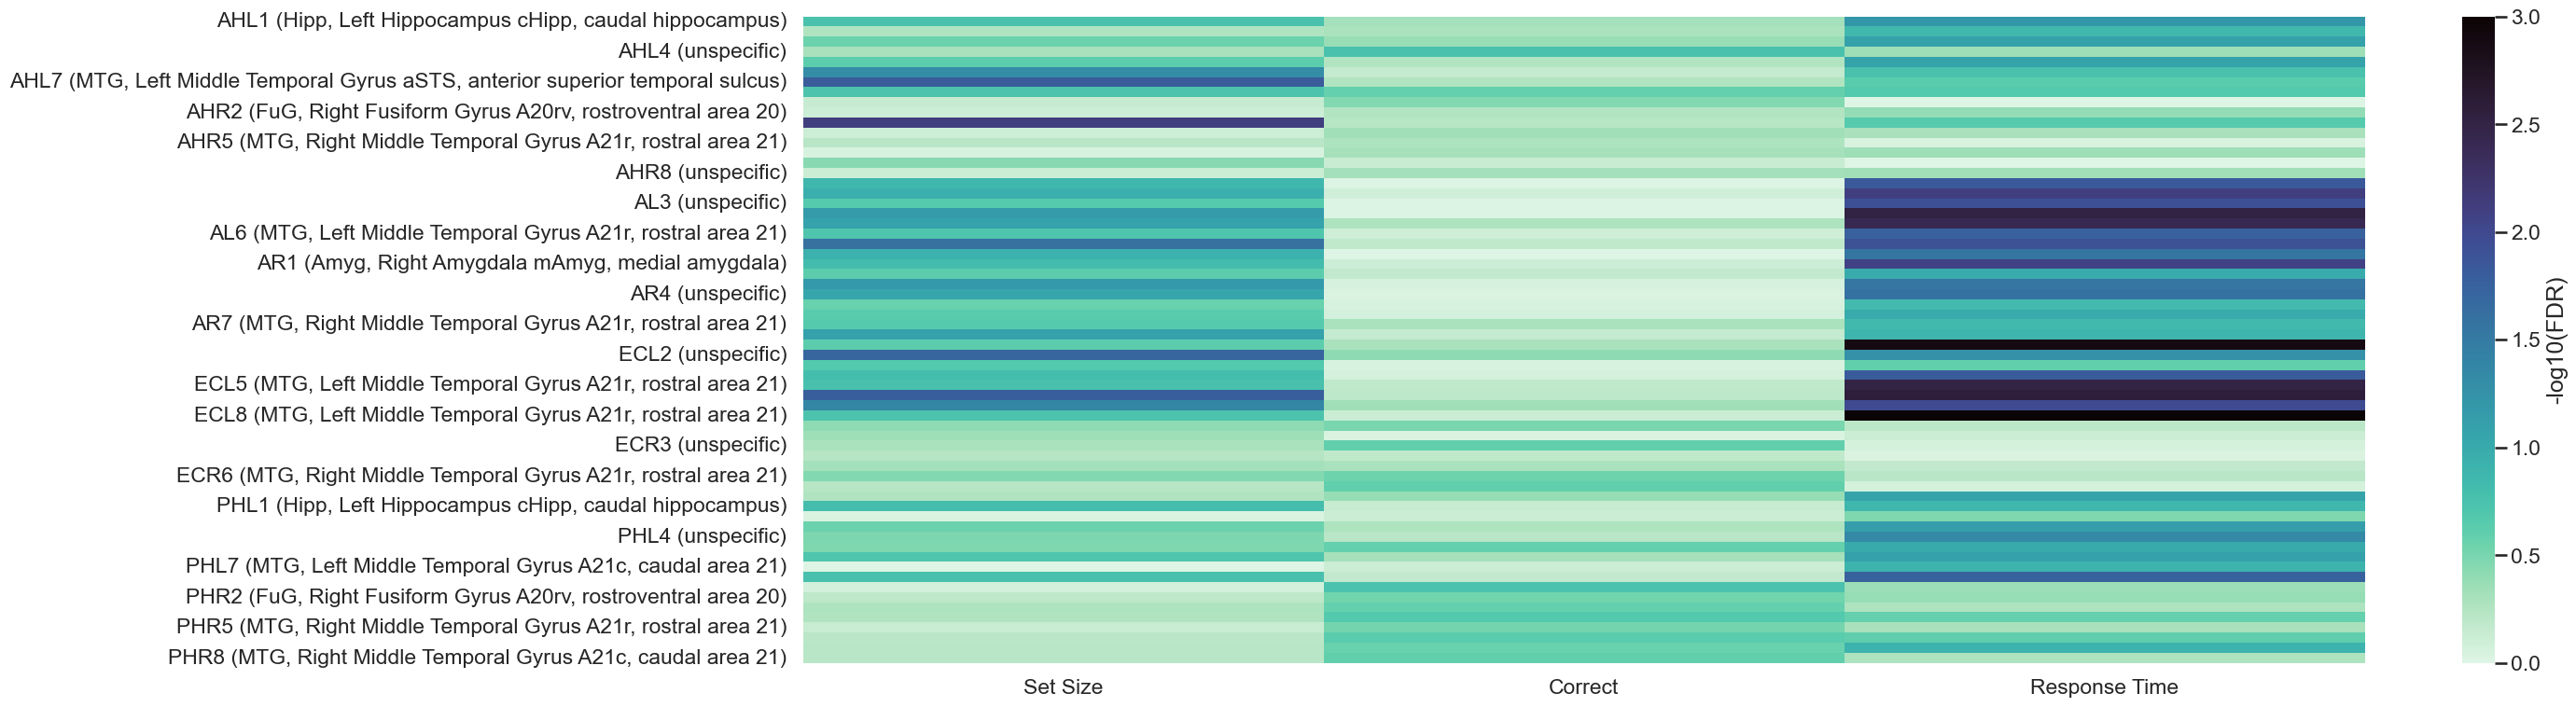

In [12]:
# Plot correlation heatmaps between magnitude and behavior
# Format waveforms into df
df = pd.DataFrame(
    micro_data['waveform'],
    index=micro_data['time'],
    columns=[f'{n} ({l})' for n, l in zip(micro_data['electrodes'], micro_data['electrode_regions'])])

# Label by trial
df['Trial'] = (
    np.arange(micro_meta['trial'].shape[0])
    .reshape(-1, 1)
    .repeat(int(df.shape[0] / micro_meta['trial'].shape[0]), axis=1)
    .flatten())

# Compute summary statistic
df = df.abs().groupby('Trial').max()
df = df.abs().groupby('Trial').mean()
# df = df.abs().groupby('Trial').var()

# Add targets
df['Set Size'] = micro_meta['set_size']
df['Correct'] = micro_meta['correct']
df['Response Time'] = micro_meta['response_time']
targets = ['Set Size', 'Correct', 'Response Time']

# Compute correlation
# df_corr = df.corr()
# df_corr = df_corr.loc[~df_corr.index.isin(targets), targets].T
# label = 'corr'

# Compute p-value for pearson
df_corr = pd.DataFrame(index=df.loc[:, ~df.columns.isin(targets)].columns, columns=targets)
for ind, col in product(df_corr.index, df_corr.columns):
    mask = (~df[ind].isna() * ~df[col].isna()).to_numpy()
    if mask.sum() > 1:
        _, p = scipy.stats.pearsonr(df[ind].to_numpy(), df[col].to_numpy())
    else: p = 1
    df_corr.loc[ind, col] = p
label = 'p'
# Use FDR
df_corr = df_corr.dropna()
pd.DataFrame(scipy.stats.false_discovery_control(df_corr.to_numpy().reshape(-1).astype(float)).reshape(df_corr.shape), index=df_corr.index, columns=df_corr.columns)
label = 'FDR'
# Apply -log10(p)
df_corr = df_corr.applymap(lambda x: -np.log10(x))
label = f'-log10({label})'

# Plot correlations
fig, ax = plt.subplots(1, 1, figsize=(27, 9))
# sns.heatmap(df_corr, vmin=-1, vmax=1, cmap=sns.color_palette('icefire', as_cmap=True), ax=ax)
# from matplotlib.colors import LogNorm
sns.heatmap(
    df_corr,
    vmin=0, vmax=3,
    # norm=LogNorm(),
    cmap=sns.color_palette('mako_r', as_cmap=True),
    cbar_kws={'label': label},
    ax=ax)
# plt.title(f'Session {session}')
plt.show()